## Code Modules

In [1]:
import warnings; warnings.filterwarnings('ignore')
import os,time,numpy as np,pylab as pl
from keras.preprocessing import image as kimage
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,\
GradientBoostingClassifier
from sklearn.metrics import \
accuracy_score,classification_report
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from PIL import ImageFile

## Data Loading

In [2]:
def path_to_tensor(img_path,fpath,img_size):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(img_size,img_size))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath,img_size):
    tensor_list=[path_to_tensor(img_path,fpath,img_size) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

In [3]:
fpath='../input/horse-breeds/'
names=['Akhal-Teke','Appaloosa','Orlov Trotter',
       'Vladimir Heavy Draft','Percheron',
       'Arabian','Friesian']
flist=sorted(os.listdir(fpath))
img_size=64
y=np.array([int(el[:2]) for el in flist],
           dtype='int8')-1
X=np.array(paths_to_tensor(flist,fpath,img_size),
           dtype='float32')/255
X=X.reshape(-1,3*img_size**2)
N=y.shape[0]; shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
X,y=X[shuffle_ids],y[shuffle_ids]

100%|██████████| 563/563 [00:04<00:00, 138.16it/s]


Label:  5 Arabian


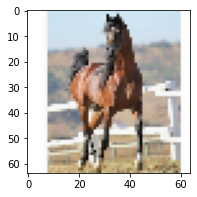

In [4]:
n=np.random.randint(400)
print('Label: ',y[n],
      names[y[n]])
pl.figure(figsize=(3,3))
pl.imshow((X.reshape(-1,img_size,img_size,3)[n]));

## Classifiers / 2 Classes

In [5]:
cond=np.where([l in [0,5] for l in y])
Xc,yc=X[cond],y[cond]
yc=np.where(yc==5,1,yc)
X_train,X_test,y_train,y_test=\
train_test_split(Xc,yc,test_size=.2,
                 random_state=1,stratify=yc)
X_train.shape,X_test.shape

((163, 12288), (41, 12288))

In [6]:
lr=LogisticRegression(C=100.0,random_state=1,
                      solver='lbfgs',multi_class='ovr')
lr.fit(X_train,y_train)
y_test_lr=lr.predict(X_test)
print('Misclassified examples: %d'%(y_test!=y_test_lr).sum())
print('Accuracy: %.3f'%accuracy_score(y_test,y_test_lr))
print("Classification Report:\n%s\n"%\
      (classification_report(y_test,y_test_lr)))

Misclassified examples: 12
Accuracy: 0.707
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75        21
           1       0.79      0.55      0.65        20

    accuracy                           0.71        41
   macro avg       0.73      0.70      0.70        41
weighted avg       0.72      0.71      0.70        41




In [7]:
svm=SVC(kernel='linear',C=1.,random_state=1)
svm.fit(X_train,y_train)
y_test_svm=svm.predict(X_test)
print('Misclassified examples: %d'%(y_test!=y_test_svm).sum())
print('Accuracy: %.3f'%accuracy_score(y_test,y_test_svm))
print("Classification Report:\n%s\n"%\
      (classification_report(y_test,y_test_svm)))

Misclassified examples: 10
Accuracy: 0.756
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        21
           1       0.86      0.60      0.71        20

    accuracy                           0.76        41
   macro avg       0.78      0.75      0.75        41
weighted avg       0.78      0.76      0.75        41




In [8]:
def plot_decision_regions(X,y,classifier,
                          test_ids=None,resolution=.05):
    markers=('$1$','$2$','$3$','$4$','$5$','$6$','$7$')
    colors=('#ff355e','#ff6037','#ffcc33','#ccff00',
            '#66ff66','#50bfe6','#ff00cc')
    X=scale(X)
    X=PCA(n_components=2).fit_transform(X)
    cmap=ListedColormap(colors[:len(np.unique(y))])
    x1_min,x1_max=X[:,0].min()-1,X[:,0].max()+1
    x2_min,x2_max=X[:,1].min()-1,X[:,1].max()+1
    xx1,xx2=np.meshgrid(np.arange(x1_min,x1_max,resolution),
                        np.arange(x2_min,x2_max,resolution))
    classifier.fit(X,y)
    Z=classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z=Z.reshape(xx1.shape)
    pl.figure(figsize=(10,10))
    pl.contourf(xx1,xx2,Z,alpha=.3,cmap=cmap)
    pl.xlim(xx1.min(),xx1.max())
    pl.ylim(xx2.min(),xx2.max())
    for ids,cl in enumerate(np.unique(y)):
        pl.scatter(x=X[y==cl,0],y=X[y==cl,1],
                   alpha=.8,c=colors[ids],
                   marker=markers[ids], 
                   label=cl,edgecolor='black')
    if test_ids:
        X_test,y_test=X[test_ids,:],y[test_ids]
        pl.scatter(X_test[:,0],X_test[:,1],
                   c='',edgecolor='black',
                   alpha=1.,linewidth=1,marker='o',
                   s=100,label='test set')

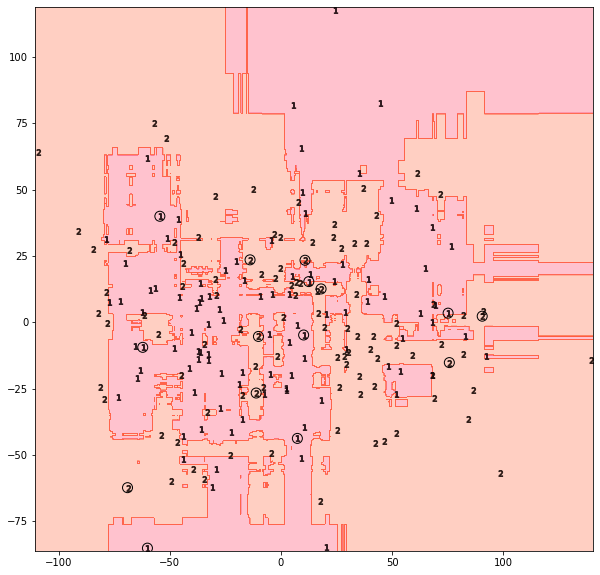

In [9]:
rf=RandomForestClassifier()
plot_decision_regions(Xc,yc,classifier=rf,
                      test_ids=range(1,16))

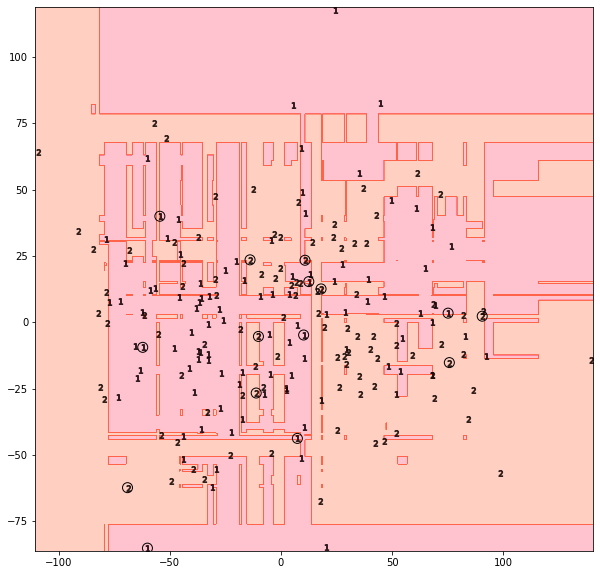

In [10]:
gb=GradientBoostingClassifier()
plot_decision_regions(Xc,yc,classifier=gb,
                      test_ids=range(1,16))

In [11]:
clf=MLPClassifier(hidden_layer_sizes=(4096,),
                  max_iter=200,solver='adam',
                  verbose=1,random_state=1,
                  learning_rate_init=.0001,
                  n_iter_no_change=50)
clf.fit(X_train,y_train)

Iteration 1, loss = 0.72716900
Iteration 2, loss = 11.99383961
Iteration 3, loss = 5.45832784
Iteration 4, loss = 1.37424088
Iteration 5, loss = 2.68105988
Iteration 6, loss = 1.92091981
Iteration 7, loss = 0.62744907
Iteration 8, loss = 1.37385199
Iteration 9, loss = 1.65335911
Iteration 10, loss = 1.06049681
Iteration 11, loss = 0.56699962
Iteration 12, loss = 0.97995068
Iteration 13, loss = 1.14037125
Iteration 14, loss = 0.87735283
Iteration 15, loss = 0.55651072
Iteration 16, loss = 0.68518301
Iteration 17, loss = 0.86925337
Iteration 18, loss = 0.76996401
Iteration 19, loss = 0.55399530
Iteration 20, loss = 0.55315829
Iteration 21, loss = 0.68266536
Iteration 22, loss = 0.67613752
Iteration 23, loss = 0.55234864
Iteration 24, loss = 0.49730696
Iteration 25, loss = 0.57217932
Iteration 26, loss = 0.59749785
Iteration 27, loss = 0.52416472
Iteration 28, loss = 0.47231114
Iteration 29, loss = 0.50529412
Iteration 30, loss = 0.53012187
Iteration 31, loss = 0.49256555
Iteration 32, lo

MLPClassifier(hidden_layer_sizes=(4096,), learning_rate_init=0.0001,
              n_iter_no_change=50, random_state=1, verbose=1)

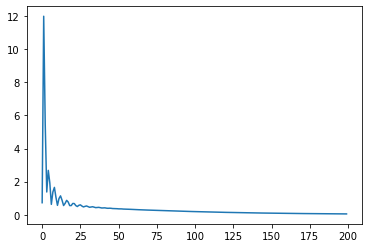

In [12]:
pl.plot(clf.loss_curve_);

0.7317073170731707


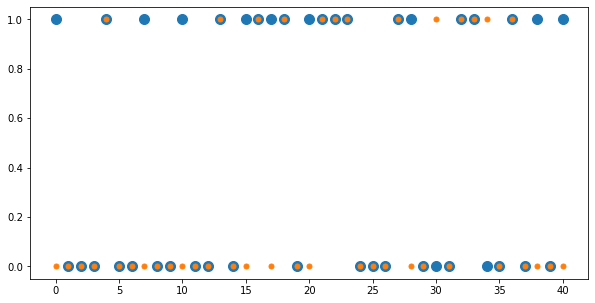

In [13]:
print(clf.score(X_test,y_test))
y_test_mlp=clf.predict(X_test)
pl.figure(figsize=(10,5))
pl.scatter(range(y_test.shape[0]),y_test,s=100)
pl.scatter(range(y_test.shape[0]),y_test_mlp,s=25);